### **[ Q.3 ] DMW_A3: Letter Recognition Using SVM (Markov Sampling)**
----

#### Group Members:
&emsp; Milan Ashvinbhai Bhuva - **IIT2018176**
<br> &emsp; Manav Kamlesh Agrawal - **IIT2018178**
<br> &emsp; Mohammed Aadil - **IIT2018179**
<br> &emsp; Ankit Kumar Rauniyar - **IIT2018202**

----

### **1. Importing libraries**

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import collections
import random
import math
from collections import Counter
import warnings

from sklearn import svm
from sklearn import metrics
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale


### **2. Importing Data**

In [8]:
letters = pd.read_csv("letter-recognition.csv")

### **3. Data Pre-processing and Visualization**

In [9]:
#Print dimension of data
print("Data dimension: ",letters.shape)

Data dimension:  (20000, 17)


In [10]:
# What the data looks like?
letters.head(15)

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
5,S,4,11,5,8,3,8,8,6,9,5,6,6,0,8,9,7
6,B,4,2,5,4,4,8,7,6,6,7,6,6,2,8,7,10
7,A,1,1,3,2,1,8,2,2,2,8,2,8,1,6,2,7
8,J,2,2,4,4,2,10,6,2,6,12,4,8,1,6,1,7
9,M,11,15,13,9,7,13,2,6,2,12,1,9,8,1,1,8


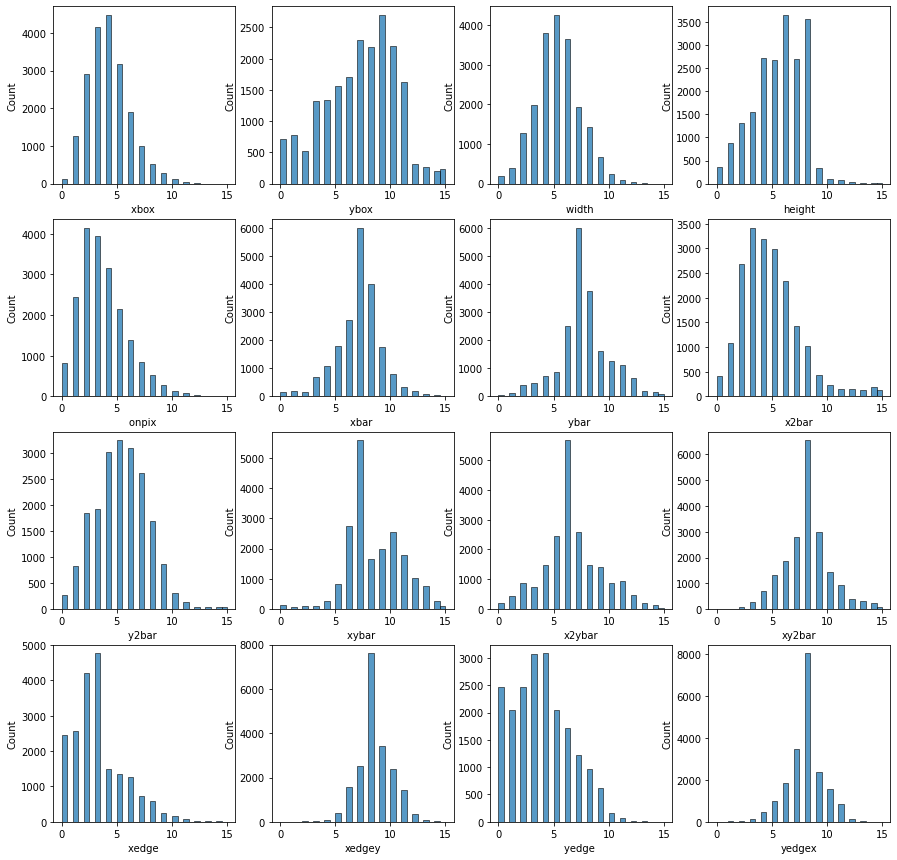

In [11]:
plt.figure(figsize=(15,15))

for i in range(1, 17):
    plt.subplot(4, 4, i)
    sns.histplot(letters.iloc[:, i], bins=30)
    
plt.show()

In [12]:
# What letters does the dataset contain?
order = list(np.sort(letters['letter'].unique()))
total = list(letters['letter'])

freq1 = {}

for i in total:
    if i not in freq1:
        freq1[i] = 1
    else:
        freq1[i] += 1

freq = dict(sorted(freq1.items()))
perc = [i/200 for i in freq.values()]
freq_df = pd.DataFrame(freq.items(), columns=['Letter', 'Frequency'])
helllinger = "poly"
freq_df['Percentage(%)'] = perc
freq_df

,Letter,Frequency,Percentage(%)
0,A,789,3.945
1,B,766,3.830
2,C,736,3.680
3,D,805,4.025
4,E,768,3.840
5,F,775,3.875
6,G,773,3.865
7,H,734,3.670
8,I,755,3.775
9,J,747,3.735


In [13]:
# Split into X and y
X = letters.drop("letter", axis = 1)
y = letters['letter']

X_scaled = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.4, random_state = 101)
print(X_train.shape)
print(y_train.shape)

(12000, 16)
(12000,)


### **4. Markov Sampling**

In [14]:
def markovSampling(X_train, Y_train):

    k = 5
    q = 1.2

    # This function applies the algorithm mentioned in the paper step-by-step.

    ''' Let m be the size of training samples and m%2 be the remainder of m divided by 2. m+ and m− denote the size of training samples which label
        are +1 and −1, respectively. Set m+ = 0 and m− = 0.'''

    # Initialise m, m_plus, and m_minus.    
    m, m_minus, m_plus = 0, 0, 0

    ''' Draw randomly N1(N1 ≤ m) training samples {zi} N1 i=1 from the dataset Dtr. '''

    # Drawing a sample from the dataset using sample().

    firstSample = np.concatenate((np.vstack(X_train), np.vstack(Y_train.to_numpy())), axis = 1)
    temp = list(firstSample)
    dataset_DTR = random.sample(temp, 8000)

    m = len(dataset_DTR)

    index = np.random.choice(m, 1, replace=False)  

    # Converting the dataset_DTR into numpy.array() form.

    updated_data = np.array(dataset_DTR)

    ''' Draw randomly a sample from Dtr and denote it the current sample zt. '''

    zt = updated_data[index][0]

    ''' If m%2 = 0, set m+ = m+ + 1 if the label of zt is +1, or set m− = m− + 1 if the label of zt is −1. '''

    if m%2 == 0:
        if zt[16] == 'A':       # Here, 'A' is taken as +1 whereas the other alphabets [B-Z] are considered as -1.
            m_plus += 1;
        else:
            m_minus += 1
    
    # Initialise f0, derivative and double derivative of P.

    f_knot = 1
    p1, p2,samples = 0, 0, []

    # Application of SVMC on linear kernel.

    model_linear = SVC(kernel='linear')
    model_linear.fit(X_train, Y_train)
    
    yzt = model_linear.predict(np.array(zt)[0:16].reshape(1, -1))
    
    ''' Set zt+1 = z∗, m+ = m+ +1 if the label of zt is +1, or set m− = m− + 1 if the label of zt is −1 '''

    if (yzt==zt[16]) == False:
        f_knot = 2 
    lzt = math.exp(0-f_knot)
    
    ''' Step 6: If m+ < m/2 or m− < m/2 then return to Step 3, else stop it. '''

    while (m_plus + m_minus < m):
        fxy = 1
        
        z_star = updated_data[np.random.choice(len(dataset_DTR), 1, replace=False)][0]
        y_star = model_linear.predict(np.array(z_star)[0:16].reshape(1, -1))
    
        if (y_star==z_star[16]) == False:
            fxy = 2 

        ''' Calculate the ratio P of e−(f0,z) at the sample z∗ and the sample zt, P = e−(f0,z∗) /e−(f0,zt). '''
        yt = zt[16]
        zt = z_star

        l_z_star = math.exp(0-fxy)

        # Computing P = e^ −(f0,z∗)/ e^ −(f0,zt)

        P = math.exp(lzt-l_z_star)

        ''' If P = 1, yt = −1 and y∗ = −1 accept z∗ with probability P '''

        if P == 1:
            if zt[16] == yt:

              ''' If P = 1, yt = 1 and y∗ = 1 accept z∗ with probability P = e^−y∗f0 /e^−ytf0 '''

              randomProbValue = random.uniform(0.001, 1.0)
              if randomProbValue <= P:

                  #Pdash = e−y∗f0 /e−ytf0
                 samples.append(z_star) 
            else:
              if yt == "A":
                candidSample_0 = 1
              else:
                candidSample_0 = -1
              
              if y_star == "A":
                candidSample = 1
              else:
                candidSample = -1
              
              randomProbValue = random.uniform(0.001, 1.0)
              p1 = math.exp(candidSample_0 * f_knot - candidSample*fxy)
              
              if randomProbValue <= p1:
                samples.append(z_star) 

        ''' If there are k candidate samples z∗ can not be accepted continuously, then set P = qP and with probability P accept z∗. '''

        if len(samples) == k:
            p2 = q*P
            samples.append(z_star)
            
        ztp1 = z_star

        if yt == 'A':
            m_plus += 1
        else:
            m_minus += 1

        if P > 1 or p1 > 1 or p2 > 1:
           samples.append(z_star)

    return samples

total_samples = np.array(markovSampling(X_train, y_train))
X_train, y_train = total_samples[:, 0:16], total_samples[:, 16]
print("Dimensionso of X_train: ",X_train.shape)

Dimensionso of X_train:  (14663, 16)


In [15]:
Y_train = []
for i in y_train:
    asciiToInt = ord(i)
    Y_train.append(asciiToInt)
print("Length of Y_train: ",len(Y_train))

Length of Y_train:  14663


### **5. Support Vector Machine** (different models)

In [16]:
acc_array = []

# Function to compute Y_test for each kernel.

def computeTest(j):
  Y_test = []
  for i in j:
    ascToInt = ord(i)
    Y_test.append(ascToInt)
  return Y_test

### **5.i) Linear Model**

In [17]:
# LINEAR

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, Y_train)

# predict
predicted_linear = model_linear.predict(X_test)

# function call
Y_test = computeTest(y_test)
    
lin_acc = metrics.accuracy_score(Y_test, predicted_linear)
acc_array.append(str(1-float(lin_acc))[:4])
print("accuracy:", lin_acc*100, "\n")

accuracy: 83.8875 



### **5.ii) RBF**

In [18]:
# RBF

model_linear = SVC(kernel='rbf')
model_linear.fit(X_train, Y_train)

# predict
predicted_rbf = model_linear.predict(X_test)

# function call
Y_test = computeTest(y_test)

rbf_acc = metrics.accuracy_score(Y_test, predicted_rbf)
acc_array.append(str(1-float(rbf_acc))[:4])
print("accuracy:", rbf_acc*100, "\n")

accuracy: 91.60000000000001 



### **5.iii Intersection**

In [19]:
def intersection(data_1, data_2):

    if np.any(data_1 < 0) or np.any(data_2 < 0):
        warnings.warn('Min kernel requires data to be strictly positive!')

    kernel = np.zeros((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        kernel += np.minimum(column_1, column_2.T)

    return kernel

# function call
Y_test = computeTest(y_test)

# Intersection Kernel
model_intersection = SVC(kernel=intersection, C=1E01,tol=0.1)
model_intersection.fit(X_train, Y_train)

predicted_intersection = model_intersection.predict(X_test)
print("Intersection Kernel Done")

int_acc = metrics.accuracy_score(y_true=Y_test, y_pred=predicted_intersection)
acc_array.append(str(1-float(int_acc))[:4])
print("accuracy:", int_acc*100, "\n")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Min kernel requires data to be strictly positive!
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Min kernel requires data to be strictly positive!
  after removing the cwd from sys.path.


Intersection Kernel Done
accuracy: 88.8875 



### **5.iv) Hellinger**

In [20]:
#Hellinger

def hellinger(p, q):
    helinger = norm(np.sqrt(p) - np.sqrt(q)) / np.sqrt(2)
    return helinger

model_linear = SVC(kernel=helllinger)
model_linear.fit(X_train, Y_train)

# predict
predicted_hellinger = model_linear.predict(X_test)

# function call
Y_test = computeTest(y_test)

accuracy_helgnr = metrics.accuracy_score(Y_test, predicted_hellinger)
acc_array.append(str(1-float(accuracy_helgnr))[:4])
print("accuracy:", accuracy_helgnr*100, "\n")

accuracy: 86.075 



### **5.v CHI^2**

In [21]:
# CHI^2 KERNEL

from sklearn.metrics.pairwise import chi2_kernel
try:
  # Chi^2 Kernel
  model_chi2 = SVC(kernel=chi2_kernel, C=1E01,tol=0.1)
  try:
    model_chi2.fit(X_train, Y_train)
  except:
    print()
  predicted_chi2 = model_chi2.predict(X_train)


  # function call
  Y_test = Y_test(y_test)

  accuracy = metrics.accuracy_score(Y_test, predicted_chi2)
  acc_array.append("NaN")
  print("accuracy: ", accuracy*100, "%")
except:
  acc_array.append("NaN")

### **6. Tabular Representation**

In [22]:
table = pd.DataFrame(columns=['Kernel', 'KPCA', 'SVDD', 'OCSVM', 'OCSSVM', 'OCSSVM with SMO', 'MS_SVM'])
table['Kernel'] = ['Linear', 'RBF', 'Intersection', 'Hellinger', 'χ2']
table['KPCA'] = ['0.02', '0.05', '0.18', '0.01', '0.18']
table['SVDD'] = ['0.09', '0.07', '0.01', '0.02', '0.00']
table['OCSVM'] = ['0.01', '0.14', '0.04', '0.02', '0.02']
table['OCSSVM'] = ['0.07', '0.09', '0.26', '0.13', '0.18']
table['OCSSVM with SMO'] = ['0.04', '0.04', '0.22', '0.10', '0.17']
table['MS_SVM'] = acc_array
table

,Kernel,KPCA,SVDD,OCSVM,OCSSVM,OCSSVM with SMO,MS_SVM
0,Linear,0.02,0.09,0.01,0.07,0.04,0.16
1,RBF,0.05,0.07,0.14,0.09,0.04,0.08
2,Intersection,0.18,0.01,0.04,0.26,0.22,0.11
3,Hellinger,0.01,0.02,0.02,0.13,0.10,0.13
4,χ2,0.18,0.00,0.02,0.18,0.17,NaN


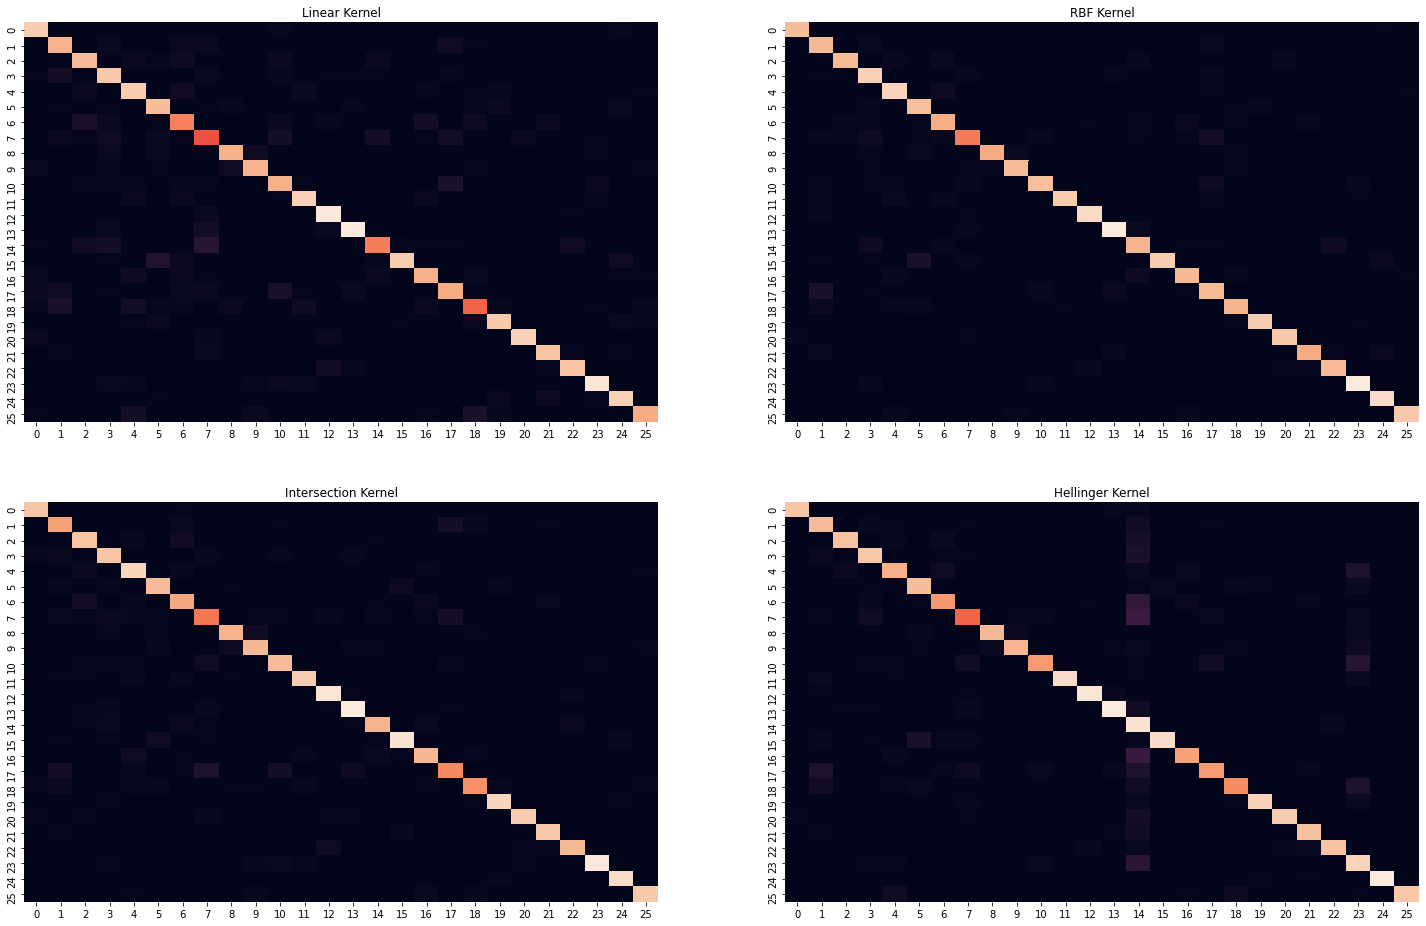

In [23]:
from sklearn.metrics import confusion_matrix

plt.subplots(figsize=(25,25))

plt.subplot(3,2,1)
cf_matrix = confusion_matrix(Y_test, predicted_linear)
plt.title('Linear Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,2)
cf_matrix = confusion_matrix(Y_test, predicted_rbf)
plt.title('RBF Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,3)
cf_matrix = confusion_matrix(Y_test, predicted_intersection)
plt.title('Intersection Kernel')
sns.heatmap(cf_matrix, cbar=False)

plt.subplot(3,2,4)
cf_matrix = confusion_matrix(Y_test, predicted_hellinger)
plt.title('Hellinger Kernel')
sns.heatmap(cf_matrix, cbar=False)

'''
plt.subplot(3,2,5)
cf_matrix = confusion_matrix(Y_test, predicted_chi2)
plt.title('Chi^2 Kernel')
sns.heatmap(cf_matrix, cbar=False)
'''

plt.show()